In [4]:
import util
%matplotlib inline
%precision 4
import pystan
import numpy as np
import pandas as pd



In [56]:
year = 2016
tag = 'top-200'
limit = 200
sqlTxt = '''
select * from (select year, player_id, row_number from rank_view where year = %s  limit %s) r 
    join scores_view s 
    using (player_id, year) order by r.row_number, player_id, year, permanent_tournament_id, round;
'''
scores = util.pd_from_sql(sqlTxt, [year, limit])
num_scores = len (scores)
player_ids = scores['player_id'].unique()
num_players = len (player_ids)
player_map = dict(zip(player_ids, range(1,num_players + 1)))
player_map_reverse = dict(zip(range(1,num_players + 1), player_ids, ))
tournament_ids = scores['permanent_tournament_id'].unique()
num_tournaments = len (tournament_ids)
tournament_map = dict(zip(tournament_ids, range(1, num_tournaments + 1)))
tournament_map_reverse = dict(zip(range(1, num_tournaments + 1), tournament_ids))
datum = sorted([[player_map[i[0]], tournament_map[i[4]], i[6]] for i in scores.as_matrix()], key = lambda (el): el[0])
p, t, y = zip(*datum)
rounds = np.zeros([limit])
for s in p:
    rounds[s-1] += 1
rounds = rounds.tolist()

In [57]:
code = """
data {
  int N;
  int N_P;
  int N_T;
  int y[N];
  int p[N];
  int t[N];
  real rounds[N_P];
}
# Trending Model
parameters {
  real alpha[N_T];
  real<lower=0, upper=7> sigma[N_P];
  real<lower=65, upper=75> tau[N_P];
  real<lower=-2, upper=2> beta[N_P];
} 
model {
  real trend = 0;
  real m = 1;
  real scale = 1.0/70.0;  #  average score
  alpha ~ normal(0, 2);
  y[1] ~ normal(alpha[t[1]] + tau[p[1]], sigma[p[1]]);
  for (n in 2:N) {
    if (p[n] != p[n-1])
      m = n;
    trend = 1 - beta[p[n]]*scale/2 + beta[p[n]]*(n-m)*scale/rounds[p[n]];
    y[n] ~ normal(alpha[t[n]] + tau[p[n]]*trend, sigma[p[n]]);
    
  } 
}

"""
data = {
    'N': num_scores,
    'y': y,
    'p' : p,
    't' : t,
    'N_P' : num_players,
    'N_T' : num_tournaments,
    'rounds' : rounds
}

fit = pystan.stan(model_code=code, data=data, iter=1000, chains=4)
params = fs = fit.summary()['summary']
print fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3bf1390da69709b20e00f7f57a82b77 NOW.


Inference for Stan model: anon_model_a3bf1390da69709b20e00f7f57a82b77.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]    -2.51    0.05   0.31  -3.13  -2.72  -2.51   -2.3  -1.89   43.0   1.09
alpha[1]    -0.03    0.05   0.31  -0.62  -0.23  -0.02   0.17   0.61   41.0    1.1
alpha[2]     0.93    0.05   0.31   0.34   0.71   0.92   1.13   1.57   44.0   1.09
alpha[3]     1.51    0.05   0.31    0.9    1.3   1.52   1.73   2.11   43.0   1.09
alpha[4]     2.01    0.05   0.31   1.39    1.8    2.0   2.21   2.62   41.0   1.09
alpha[5]    -0.73    0.08   0.31  -1.36  -0.93  -0.73  -0.52  -0.12   15.0   1.09
alpha[6]     1.14    0.08   0.31   0.56   0.93   1.14   1.34   1.75   13.0   1.11
alpha[7]     0.85    0.05   0.32   0.22   0.64   0.85   1.07   1.48   49.0   1.08
alpha[8]    -0.33    0.05   0.32  -0.94  -0.55  -0.34  -0.13   0.32   46.0 

In [58]:
t_range = range(0,num_tournaments)
d = {
    'permanent_tournament_id': pd.Series([tournament_map_reverse[i+1] for i in t_range]),
    'tag': pd.Series([tag for i in t_range]),
    'year' : pd.Series([year for i in t_range]),
    'alpha': pd.Series([(round(params[i][0],3), round(params[i][1],3), round(params[i][2],3)) for i in t_range]),
}
t_stats = pd.DataFrame(d)
t_stats.to_sql(name= 'stan_tournaments', con= util.golf_engine, if_exists= 'append', index=False)


In [59]:
p_range = range(0,num_players)

def create_stat(parm, i, offset):
    i += offset
    return (round(parm[i][0],3), round(parm[i][1],3), round(parm[i][2],3))

d = {
    'player_id': pd.Series([player_map_reverse[i+1] for i in p_range]),
    'tag': pd.Series([tag for i in p_range]),
    'year' : pd.Series([year for i in p_range]),  
    'sigma': pd.Series([create_stat(params, i, num_tournaments ) for i in p_range]),
    'tau': pd.Series([create_stat(params, i, num_tournaments+num_players ) for i in p_range]),
    'beta': pd.Series([create_stat(params, i, num_tournaments+2*num_players ) for i in p_range])
}
p_stats = pd.DataFrame(d)
p_stats.to_sql(name= 'stan_players', con= util.golf_engine, if_exists= 'append', index=False)

0.0344736842105
3.1308 3.40579234632


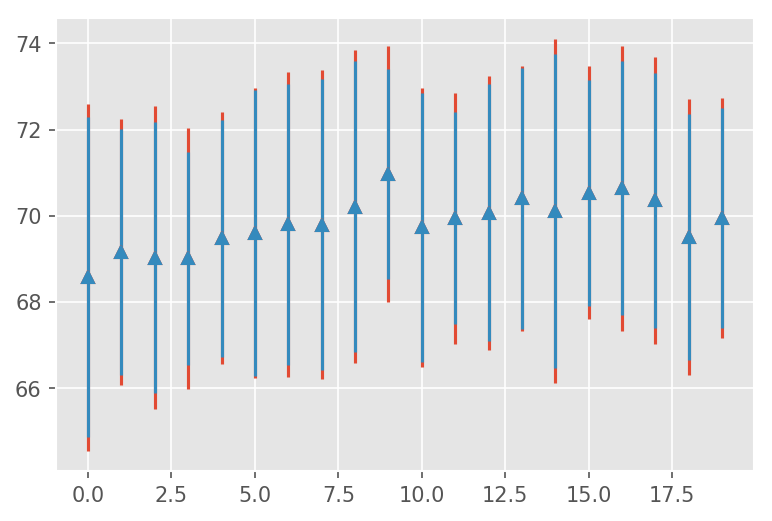

In [21]:
# offset = np.mean([round(means[i][0],2) for i in range(0,num_tournaments)])
# print offset
# top_players = 20
# avg_score = [round(means[i][0],2) for i in range(num_tournaments+num_players,num_tournaments+2*num_players)]
# std_score = [round(means[i][0],2) for i in range(num_tournaments,num_tournaments+num_players)]
# sqlTxt = '''
# select * from stats_view where year = 2014 limit 100; 
# '''
# df = util.pd_from_sql(sqlTxt)
# # foo = plt.errorbar(range(0, top_players), df['avg_score'][0:top_players], df['std_score'][0:top_players], linestyle='None', marker='^')
# foo = plt.errorbar(range(0, top_players), avg_score[0:top_players] + offset, df['std_score'][0:top_players], linestyle='None', marker='^')
# foo = plt.errorbar(range(0, top_players), avg_score[0:top_players] + offset, std_score[0:top_players], linestyle='None', marker='^')
# print np.mean(std_score), np.mean(df['std_score']) 
